What this code does
1. Runs all TSM code for the Sun
1. Adds noise to the data
1. Bins it
1. Then finds an equation for the background
1. Then finds the gaussian on that background
1. Locates V_max

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as c
from scipy.signal import find_peaks
from scipy.signal import peak_prominences
from scipy.signal import peak_widths
from scipy.optimize import curve_fit
import math
from statistics import stdev 

## Bin_it
This function bins one array and reduces another array to match its length so they can be plotted together. This is done to reduce the noise whihc comes from the noise on the data.
###  Inputs
- yvalues: y array, the Power normally called Fulldata in this code
- xvalues: x array, the frequency
- binsize: the size of the bin the y values will be averaged in, every binsizeth value will also be taken from the x array<br>
### Outputs
- Binned y array (Power)
- reduced x array (Frequency)

In [3]:
def bin_it(yvalues,xvalues,binsize):
    '''puts an array into averaged bins of a given size'''
    N=int(math.ceil(len(yvalues)/binsize))
    C=0
    newy=[]
    while C<N:
        if (C+1)*binsize<len(yvalues):
            Q=(np.sum(yvalues[C*binsize:(C+1)*binsize]))/binsize
        else:
            Q=(np.sum(yvalues[C*binsize:len(yvalues)]))/binsize
        newy.append(Q)
        C+=1
    y=np.array(newy)
    x=xvalues[0::binsize] 
    return y[0:len(y)-1],x[0:len(y)-1]

## addnoise
adds noise to and array. The method used to generate the noise was taken from a recommended scientific paper
### Input
- pure: orignal array
### output
- array with noise added

In [4]:
#Adds random noise
def addnoise(pure):
    vary = np.random.uniform(0, 1, pure.shape)
    signal = -(pure* np.log(vary))
    return signal

## gausgran
Is the equation of a gaussian where the base is not just a flat line, it is adjusted by an array fitted to the background called fittedgran.
### Inputs
- x: array over which the gaussian with background should be plotted
- height: Height of the gaussian
- centre: Centre of the gaussian
- width: Width of the gaussain at half its height
### Output
- An equation with gives a gaussian on a line fitted to the background of the data

In [5]:
def gausgran(x,height,centre,width):
    '''plots a gaussian acounting for granulation'''
    return height*np.exp((-(x-centre)**2)/(2*width**2))+fittedgran

## gausgran1
Very similar to gausgran except the fittedgran is reduced so a plot can be done around the envelope. The cropping is hard coded so not applicable to all stars
### Inputs
- x: array over which the gaussian with background should be plotted
- height: Height of the gaussian
- centre: Centre of the gaussian
- width: Width of the gaussain at half its height
### Output
- An equation with gives a cropped gaussian on a line fitted to the background of the data

In [6]:
def gausgran1(x,height,centre,width):
    '''plots a gaussian acounting for granulation'''
    return height*np.exp((-(x-centre)**2)/(2*width**2))+fittedgran[quater:3*quater]

## count
Find the number of values in an array between two given values
### Inputs
- list1: array to be analysed
- l: lower limit of count
- r: upper limit of count
### Output
- number of values in list1 between l and r

In [7]:
def count(list1, l, r): 
    # x for x in list1 is same as traversal in the list 
    # the if condition checks for the number of numbers in the range  
    # l to r  
    # the return is stored in a list 
    # whose length is the answer 
    return len(list(x for x in list1 if l <= x <= r)) 

## findgran
Finds an equation which describes the background noise of the initial data and returns the values needed to plot the background
### Inputs
- x: x value array (frequency) 
- y: y value arrat (power)
### Output
- best_vals is an array of to integers which can be put into graneq to fit the background noise

In [8]:
def findgran(x,y):
    #guess_vals=[np.max(y),y[round(len(y)/4)]]
    guess_vals=[0, 0]
    best_vals, covar =curve_fit(graneq, x, y,p0=guess_vals)
    return best_vals

## graneq
plots returns the y values of the background if the x array and two constants are inserted
### Inputs
- x: x array (frequency)
- A: constant calulated by findgran
- tau: constant calulated by findgran
### Output
- array of y values of the background

In [9]:
def graneq(x,A,tau):
    '''equation to describe the background'''
    return A/(1+(2*np.pi*x*tau)**2)+SN

In [11]:
data = np.genfromtxt('Kypoints.txt', delimiter=' ')
extradata = np.genfromtxt('Kotherstuff.txt', delimiter=' ')

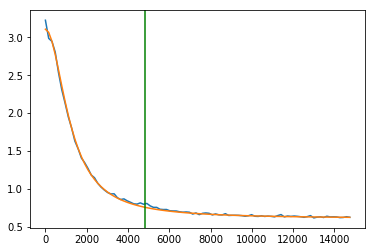

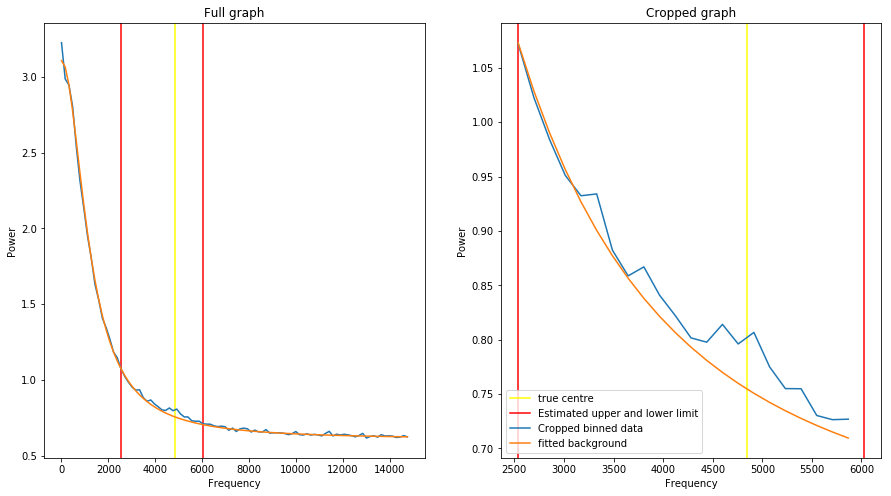

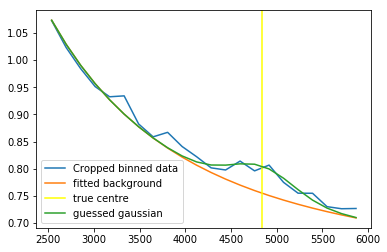

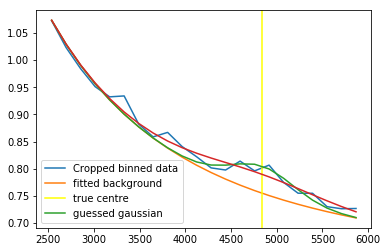

average v_max 4800.18415585113 which is -43.349421441479535 away from the true value of 4843.533577292609


In [35]:
frequency=data[0]
y,x=bin_it(addnoise(data[1]),frequency,6000)
plt.plot(x,y)
SN = 18*10**(-0.4*(11.0-extradata[0,2]))
p0=[0,0,0.1,extradata[0,1],300] #[A,tau,height,centre,width]
bv,covar =curve_fit(graneq,x,y,p0=[0,0])
background=graneq(x,bv[0],bv[1])
plt.plot(x,background)
plt.axvline(extradata[0,1],color='yellow')
#best_vals, covar =curve_fit(fullfit, x, y,p0=p0,maxfev=8000 )
#plt.plot(x,fullfit(x,best_vals[0],best_vals[1],best_vals[2],best_vals[3],best_vals[4]))
plt.show()
#lowerlim = input('Estimate the lower end of p modes: ')
#upperlim = input('Estimate the upper end of p modes: ') #user estimates the sides of the p modes
lowerlim=2500
upperlim=6000
lowerxindex=find_nearest(x,int(lowerlim))
upperxindex=find_nearest(x,int(upperlim)) 
fbackground=background[lowerxindex:upperxindex]
yf=y[lowerxindex:upperxindex]
xf=x[lowerxindex:upperxindex] #crops y and x array using entered limits xf and yf for xfinal and y final
fig, (ax1,ax2) = plt.subplots(1, 2 ,figsize=(15,8)) #genrates needed subplots
ax1.axvline(extradata[0,1],color='yellow',label='true centre')
ax1.axvline(int(x[lowerxindex]),color='red')
ax1.axvline(int(x[upperxindex]),color='red',label='Estimated upper and lower limit') #plots entered limits
ax1.set_xlabel('Frequency')
ax1.set_ylabel('Power')
ax1.set_title('Full graph')
ax1.plot(x,y,label='Binned data') 
ax1.plot(x,background,label='fitted background')
ax2.axvline(extradata[0,1],color='yellow',label='true centre')
ax2.axvline(int(x[lowerxindex]),color='red')
ax2.axvline(int(x[upperxindex]),color='red',label='Estimated upper and lower limit') #plots entered limits
ax2.plot(xf,yf,label='Cropped binned data')
ax2.plot(xf,fbackground,label='fitted background')
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Power')
ax2.set_title('Cropped graph')
ax2.legend()
plt.show()
fittedgran=fbackground
plt.plot(xf,yf,label='Cropped binned data')
plt.plot(xf,fbackground,label='fitted background')
plt.axvline(extradata[0,1],color='yellow',label='true centre')
p0=[0.05,extradata[0,1],350]
plt.plot(xf,gausgran(xf,p0[0],p0[1],p0[2]),label='guessed gaussian')
plt.legend()
plt.show()
best_vals, covar = curve_fit(gausgran,xf,yf,p0=p0)
plt.plot(xf,yf,label='Cropped binned data')
plt.plot(xf,fbackground,label='fitted background')
plt.axvline(extradata[0,1],color='yellow',label='true centre')
p0=[0.05,extradata[0,1],350]
plt.plot(xf,gausgran(xf,p0[0],p0[1],p0[2]),label='guessed gaussian')
plt.plot(xf,gausgran(xf,best_vals[0],best_vals[1],best_vals[2]))
plt.legend()
plt.show()
print(f'average v_max {best_vals[1]} which is {best_vals[1]-extradata[0,1]} away from the true value of {extradata[0,1]}')

# this bit

Code is 25.0% complete :)
Code is 50.0% complete :)
Code is 75.0% complete :)
Code is 100.0% complete :)
0/1000 trails failed
average v_max 5009.110328546791 which is 165.57675125418154 away from the true value of 4843.533577292609


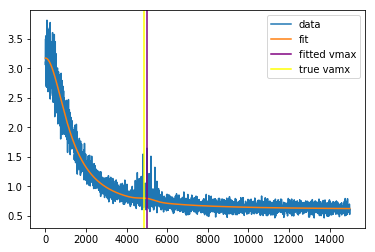

In [14]:
frequency=data[0]
N=1000
C=0
fails=0
amps=[]
centres=[]
widths=[]
while C<N:
    y,x=bin_it(addnoise(data[1]),frequency,120)
    SN = 18*10**(-0.4*(11.0-extradata[0,2]))
    p0=[0,0,0.1,extradata[0,1],300] #[A,tau,height,centre,width]
    bv,covar =curve_fit(graneq,x,y,p0=[0,0])
    background=graneq(x,bv[0],bv[1])
    fittedgran=background
    p0=[0.05,extradata[0,1],350]
    try:
        best_vals, covar = curve_fit(gausgran,x,y,p0=p0)
        amps.append(best_vals[0])
        centres.append(best_vals[1])
        widths.append(best_vals[2])
        C+=1
        if C % (25*(N/100)) == 0:
            print(f'Code is {C/(N/100)}% complete :)') #if statment that allows tracking of code completion while it is running
    except:
        fails+=1
        C+=1
        if C % (25*(N/100)) == 0:
            print(f'Code is {C/(N/100)}% complete :(') #if statment that allows tracking of code completion while it is running
if len(centres)>0:
    average_v_max=np.mean(centres)
    difference=np.abs(average_v_max-extradata[0,1])
    print(f'{fails}/{N} trails failed')
    print(f'average v_max {average_v_max} which is {difference} away from the true value of {extradata[0,1]}')
    plt.plot(x,y,label='data')
    plt.plot(x,gausgran(x,np.mean(amps),np.mean(centres),np.mean(widths)),label='fit')
    plt.axvline(np.mean(centres),label='fitted vmax',color='purple')
    plt.axvline(extradata[0,1],label='true vamx',color='yellow')
    plt.legend()
    plt.show()
else:
    print('fails')

In [34]:
def vmaxloop(powerdata,truevmax,truevmag,N,binsize,Starnumber):
    print(f'Star {int(Starnumber)}')
    frequency=data[0]
    C=0
    fails=0
    amps=[]
    centres=[]
    widths=[]
    while C<N:
        y,x=bin_it(addnoise(powerdata),frequency,binsize)
        SN = 18*10**(-0.4*(11.0-truevmag))
        bv,covar =curve_fit(graneq,x,y,p0=[0,0])
        background=graneq(x,bv[0],bv[1])
        fittedgran=background
        p0=[0.05,4000,350]
        try:
            best_vals, covar = curve_fit(gausgran,x,y,p0=p0)
            amps.append(best_vals[0])
            centres.append(best_vals[1])
            widths.append(best_vals[2])
            C+=1
            if C % (25*(N/100)) == 0:
                print(f'Code is {C/(N/100)}% complete') #if statment that allows tracking of code completion while it is running
        except:
            fails+=1
            C+=1
            if C % (25*(N/100)) == 0:
                print(f'Code is {C/(N/100)}% complete') #if statment that allows tracking of code completion while it is running
    if len(centres)>0:
        average_v_max=np.mean(centres)
        difference=np.abs(average_v_max-truevmax)
        print(f'{fails}/{N} trails failed')
        print(f'average v_max {average_v_max} which is {difference} away from the true value of {extradata[0,1]}')
        plt.plot(x,y,label='data')
        plt.plot(x,gausgran(x,np.mean(amps),np.mean(centres),np.mean(widths)),label='fit')
        plt.axvline(np.mean(centres),label='fitted vmax',color='purple')
        plt.axvline(truevmax,label='true vamx',color='yellow')
        plt.title(f'Star {int(Starnumber)}')
        plt.xlabel('Frequency')
        plt.ylabel('Power')
        plt.legend()
        plt.show()
    else:
        print('fails')
        plt.plot(x,y,label='data')
        plt.legend()
        plt.show()

Star 1
Code is 25.0% complete
Code is 50.0% complete
Code is 75.0% complete
Code is 100.0% complete
fails


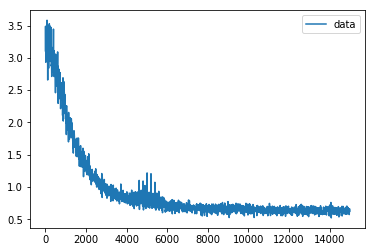

Star 2
Code is 25.0% complete
Code is 50.0% complete
Code is 75.0% complete
Code is 100.0% complete
fails


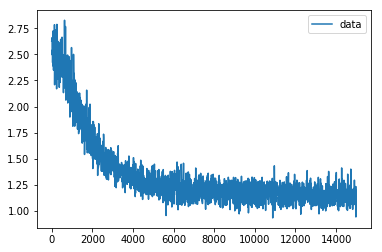

Star 3
Code is 25.0% complete
Code is 50.0% complete
Code is 75.0% complete
Code is 100.0% complete
fails


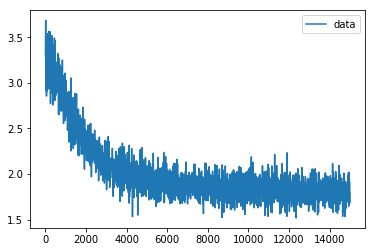

Star 4
Code is 25.0% complete
Code is 50.0% complete
Code is 75.0% complete
Code is 100.0% complete
fails


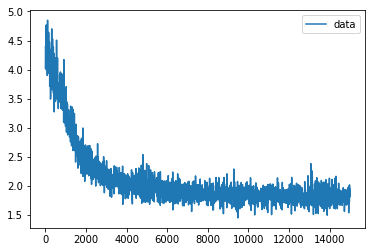

Star 5
Code is 25.0% complete
Code is 50.0% complete
Code is 75.0% complete
Code is 100.0% complete
fails


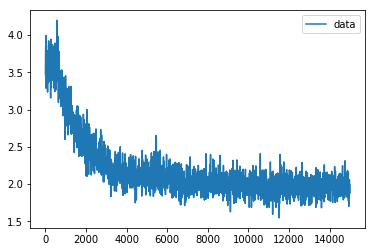

Star 6


In [ ]:
m=np.linspace(1,10,10)
binsize=250
number_of_trails=100
for n in m:
    vmaxloop(data[int(n)],extradata[int(n)-1,1],extradata[int(n)-1,2],number_of_trails,binsize,n)